# Imports

In [ ]:
from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

In [ ]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8675309 # Blessed be TTT
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

# Load Data

The data in this project is captured at two target locations: `Callao` refers to data acquired near the port of Callao in Lima, Peru. `Offshore` refers to data captured in the littoral waters southeast of Callao.

In [ ]:
callao_sat_data = pd.read_csv('../data/callao_sat_data.csv')
callao_ais_data = pd.read_csv('../data/callao_ais_data.csv')
offshore_sat_data = pd.read_csv('../data/offshore_sat_data.csv')
offshore_ais_data = pd.read_csv('../data/offshore_ais_data.csv')

# Plot Data

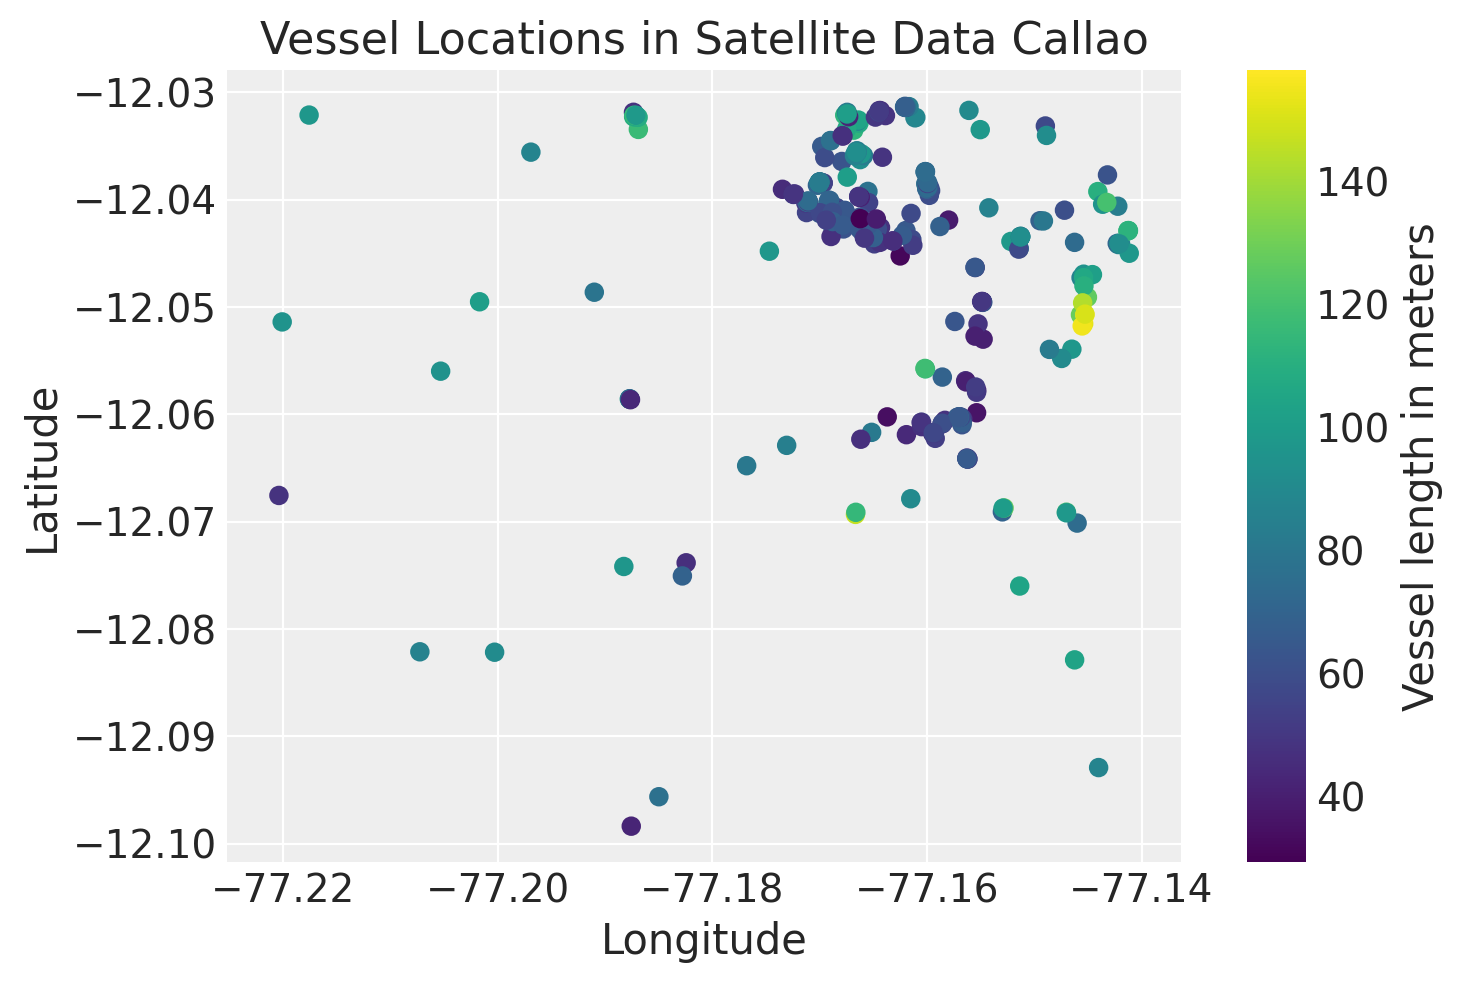

In [ ]:
plt.figure()
plt.scatter(callao_sat_data["longitude"], 
            callao_sat_data["latitude"], 
            c=callao_sat_data["length"]),
plt.title('Vessel Locations in Satellite Data Callao')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label="Vessel length in meters"), plt.axis("equal");
plt.show()

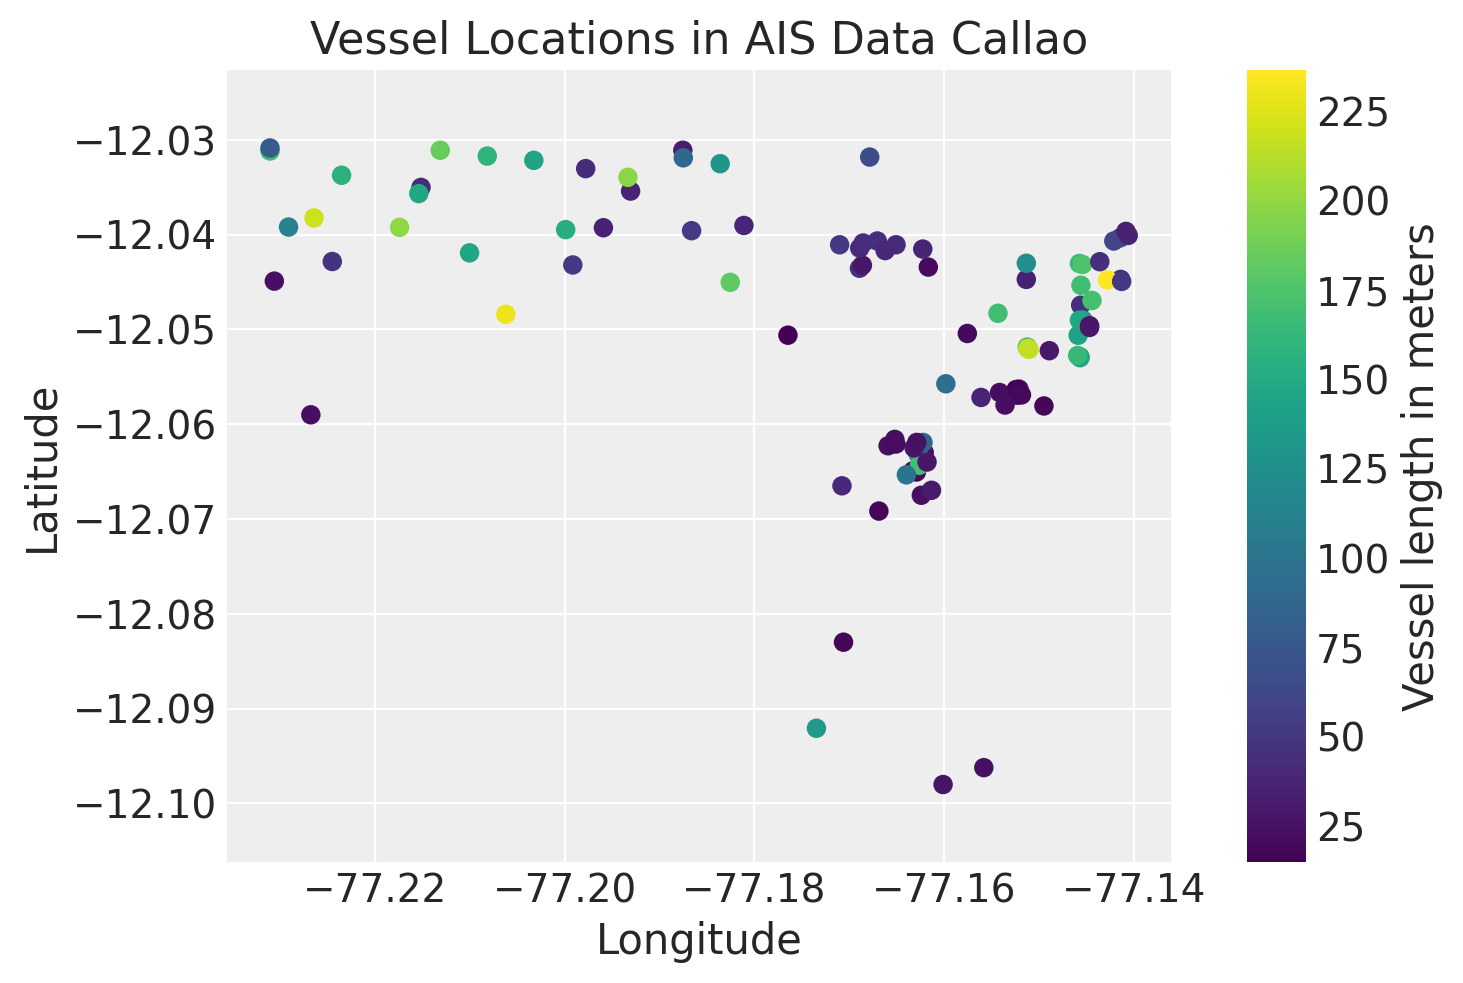

In [ ]:
plt.figure()
plt.scatter(callao_ais_data["lon"], 
            callao_ais_data["lat"], 
            c=callao_ais_data["length_m"]),
plt.title('Vessel Locations in AIS Data Callao')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label="Vessel length in meters"), plt.axis("equal");
plt.show()

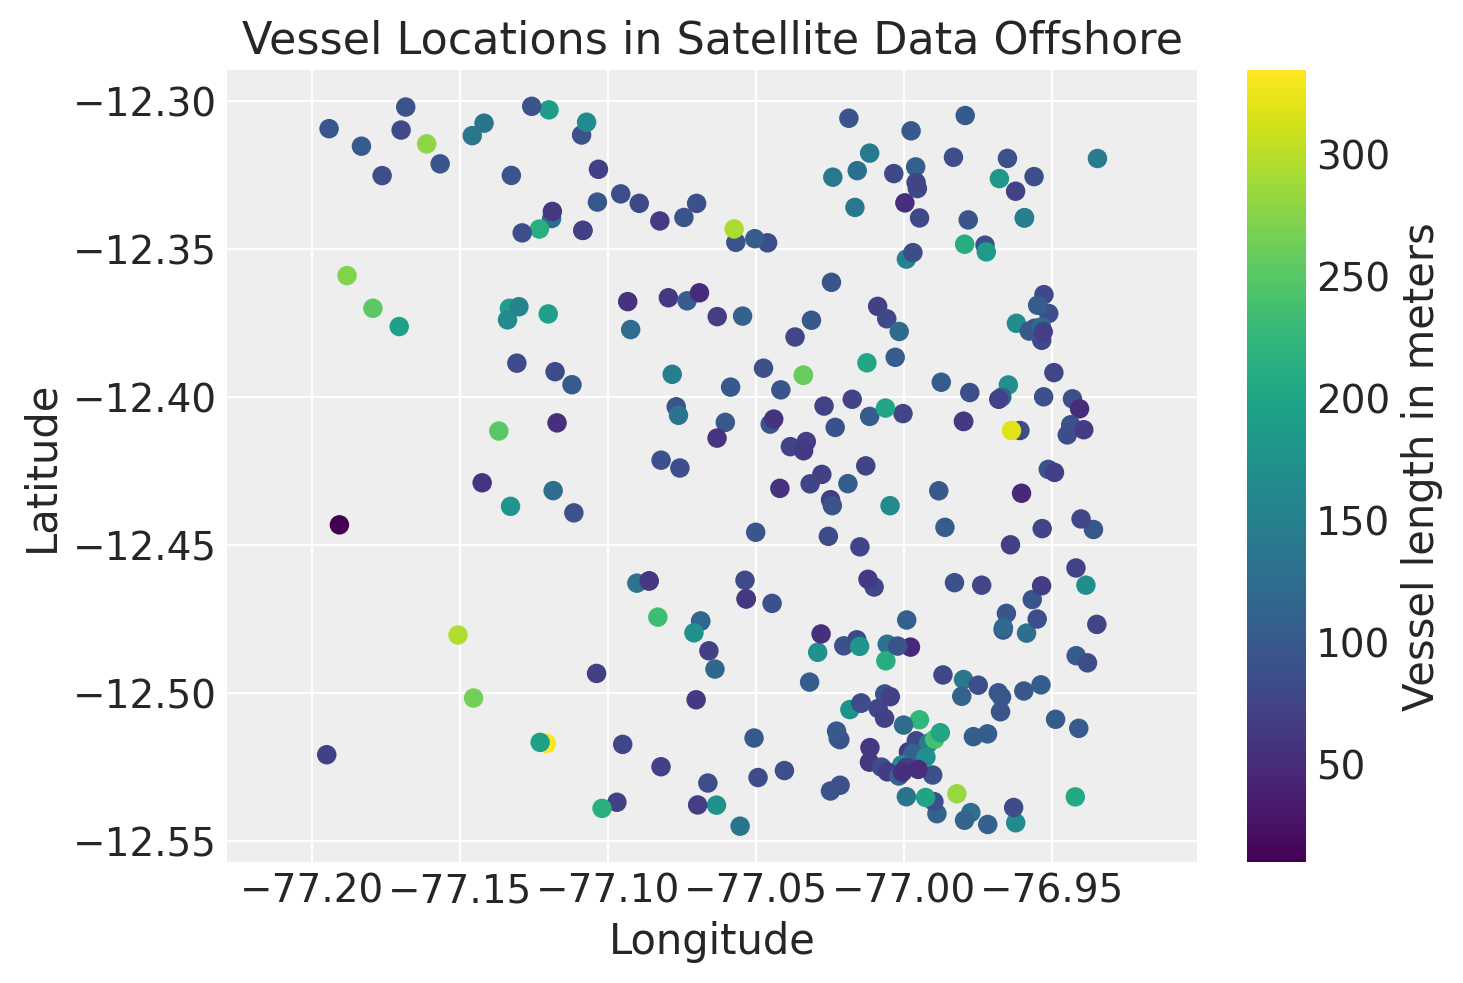

In [ ]:
plt.figure()
plt.scatter(offshore_sat_data["longitude"], 
            offshore_sat_data["latitude"], 
            c=offshore_sat_data["length"]),
plt.title('Vessel Locations in Satellite Data Offshore')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label="Vessel length in meters"), plt.axis("equal");
plt.show()

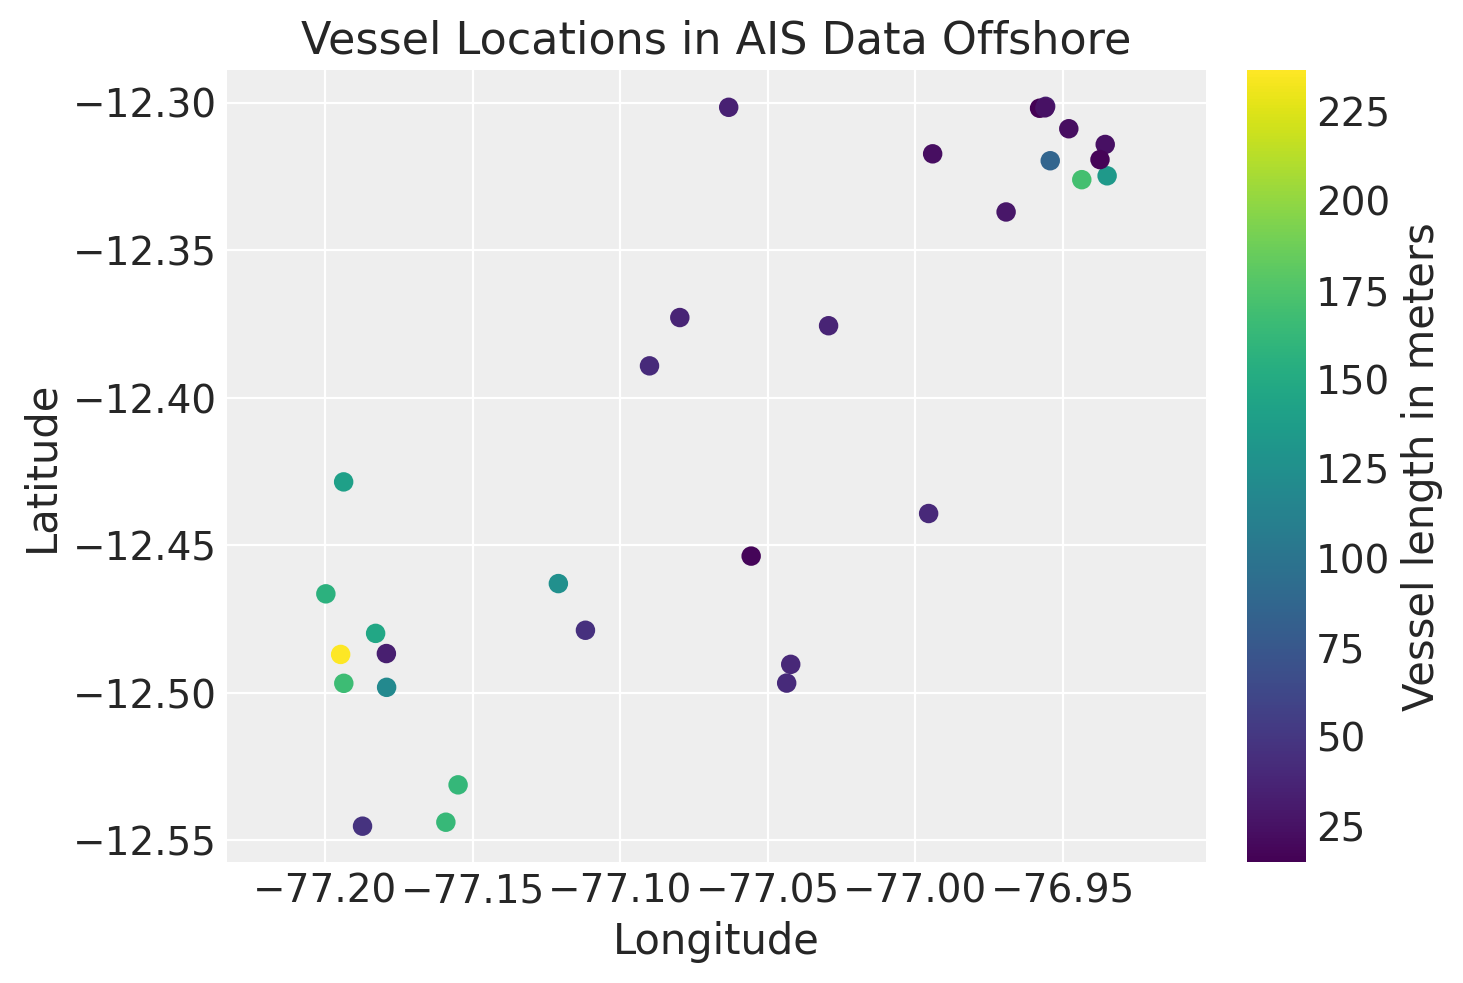

In [ ]:
plt.figure()
plt.scatter(offshore_ais_data["lon"], 
            offshore_ais_data["lat"], 
            c=offshore_ais_data["length_m"]),
plt.title('Vessel Locations in AIS Data Offshore')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label="Vessel length in meters"), plt.axis("equal");
plt.show()

# Callao

## Prepare Data for Model

In [ ]:
# Prepare data for model

# For vd model outputs
xy = callao_sat_data[['longitude', "latitude"]].values

resolution = 10 # Note: This is a small value because my compute is limited

cells_x = resolution
cells_y = resolution

# Getting the edge coordinates
min_x, max_x = -77.23114013671875, -77.13775634765625
min_y, max_y = -12.098745486944878, -12.030590362909159

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(min_x, max_x, cells_x + 1)
quadrat_y = np.linspace(min_y, max_y, cells_y + 1)

cell_x_size = (max_x - min_x) / cells_x
cell_y_size = (max_y - min_y) / cells_y

area_per_cell = cell_x_size * cell_y_size

# # Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + (cell_x_size / 2.0), 
                                    quadrat_y[:-1] + (cell_y_size / 2.0))))

cell_counts_1, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts_1 = cell_counts_1.ravel().astype(int)

# For ais data
xy = callao_ais_data[['lon', "lat"]].values

cell_counts_2, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts_2 = cell_counts_2.ravel().astype(int)
assert len(cell_counts_1) == len(cell_counts_2)

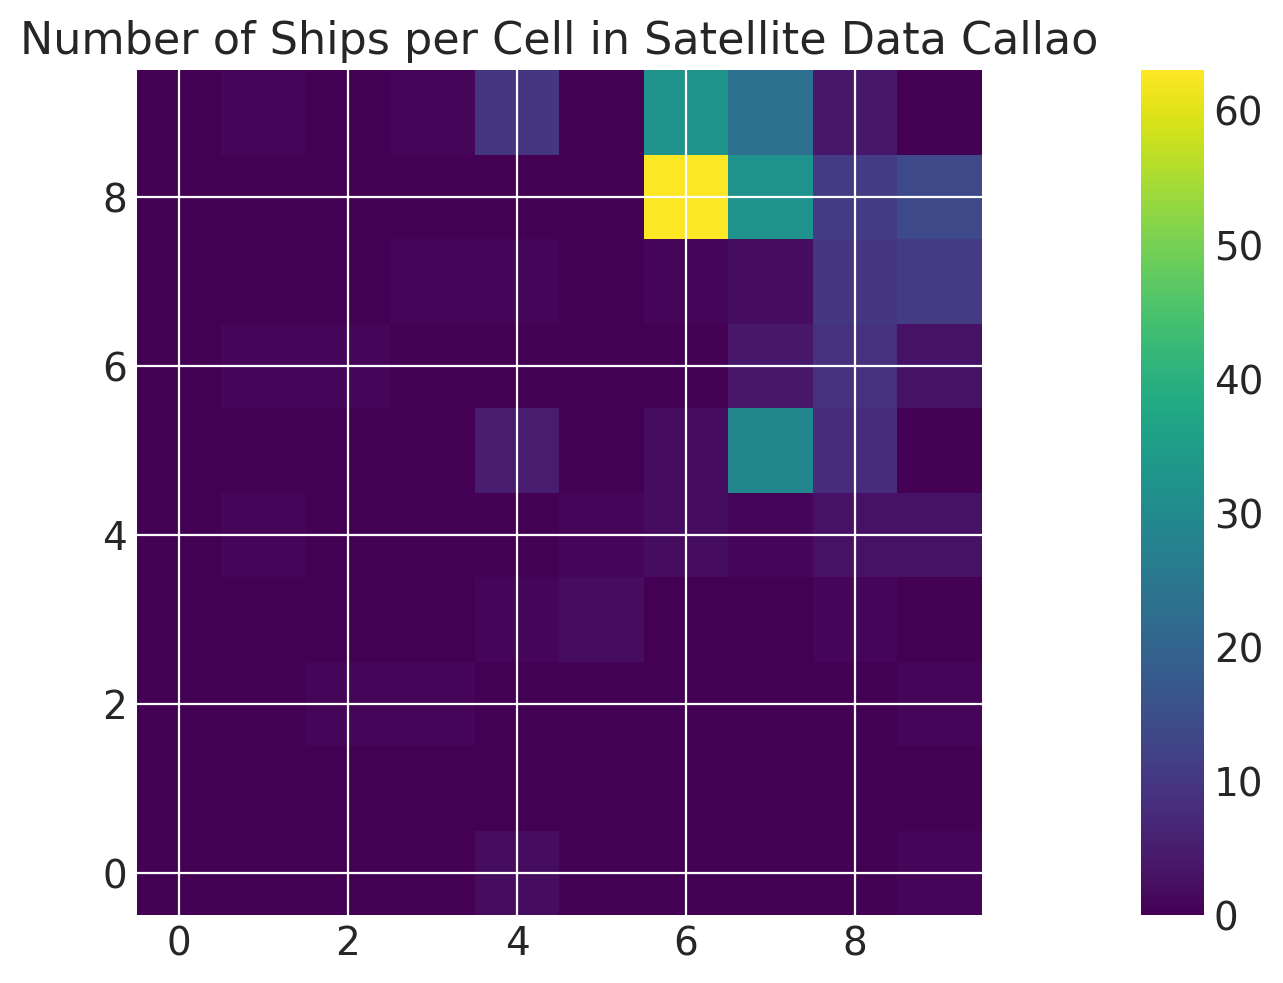

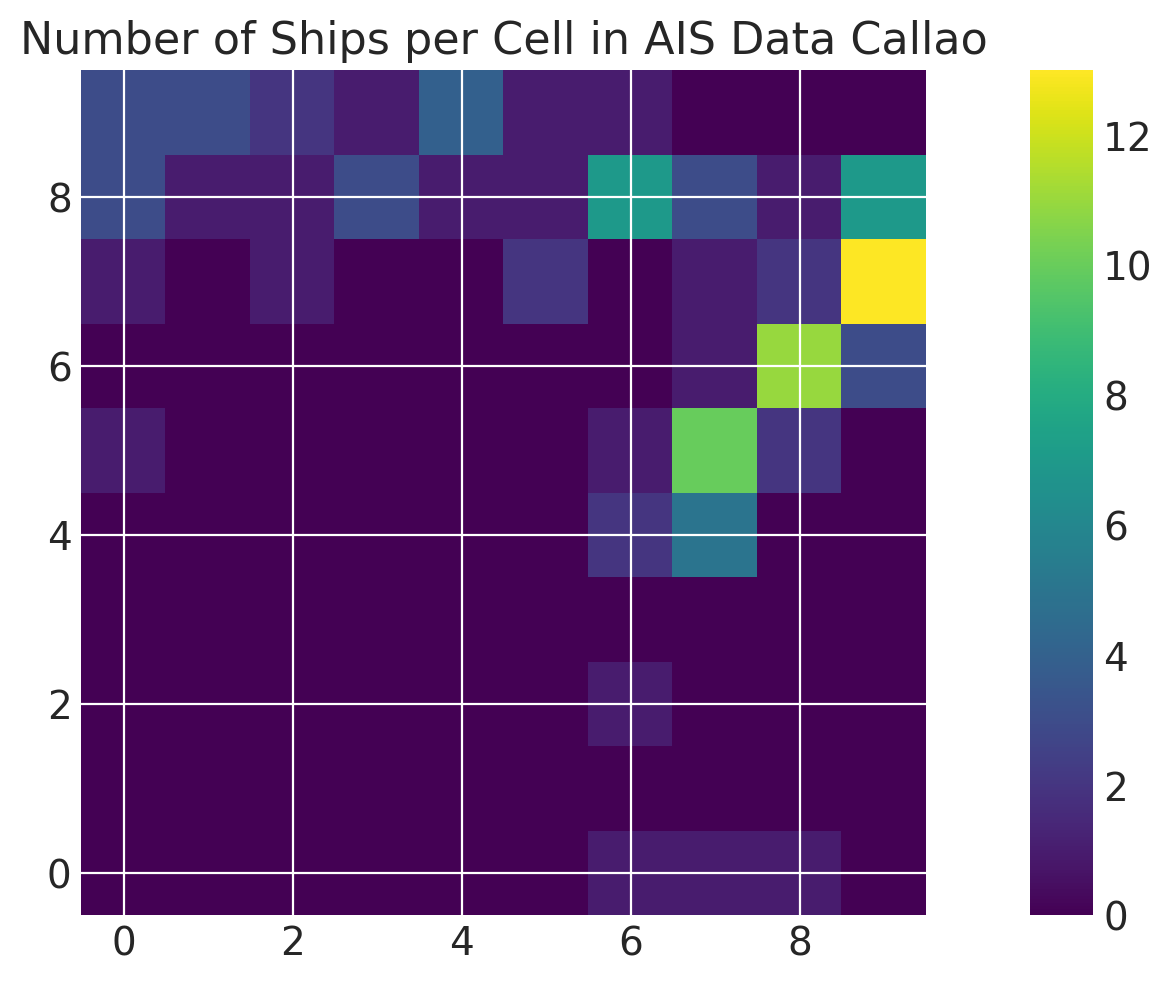

In [ ]:
plt.figure()

plt.imshow(cell_counts_1.reshape(resolution, -1).T, origin='lower')
plt.colorbar()
plt.title('Number of Ships per Cell in Satellite Data Callao')
plt.show()

plt.figure()

plt.imshow(cell_counts_2.reshape(resolution, -1).T, origin='lower')
plt.colorbar()
plt.title('Number of Ships per Cell in AIS Data Callao')
plt.show()

## Build Model

In [ ]:
# 'Vectorized" model
with pm.Model() as lgcp_model:
    mu = pm.Normal("mu", mu=0, sigma=1, shape=2)
    phi = pm.Uniform("phi", lower=0.005, upper=0.1, shape=2)
    cov_scale = pm.Exponential("scale", lam=10, shape=2)
    cov_func_1 = cov_scale[0] * pm.gp.cov.Exponential(2, ls=(0.5) \
                                                      * np.sqrt(phi[0]))
    cov_func_2 = cov_scale[1] * pm.gp.cov.Exponential(2, ls=(0.5) \
                                                      * np.sqrt(phi[1]))
    mean_func_1 = pm.gp.mean.Constant(mu[0])
    mean_func_2 = pm.gp.mean.Constant(mu[1])

    gp_1 = pm.gp.Latent(mean_func=mean_func_1, cov_func=cov_func_1)
    gp_2 = pm.gp.Latent(mean_func=mean_func_2, cov_func=cov_func_2)

    # Multitype-scpecific params
    alpha_diag = pm.InverseGamma('alpha_diag', alpha=2.0, beta=2.0, shape=2)
    alpha_21 = pm.Normal('alpha_21', sd=10)

    gp_1_prior = gp_1.prior("log_intensity_1", X=centroids) # Xs must match
    gp_2_prior = gp_2.prior("log_intensity_2", X=centroids) # Xs must match

    log_intensity_1 = alpha_diag[0] * gp_1_prior
    log_intensity_2 = alpha_21 * gp_1_prior + alpha_diag[1] * gp_2_prior 

    intensity_1 = pm.math.exp(log_intensity_1)
    intensity_2 = pm.math.exp(log_intensity_2)

    rates_1 = intensity_1 * area_per_cell
    rates_2 = intensity_2 * area_per_cell
    counts_1 = pm.Poisson("counts_1", mu=rates_1, observed=cell_counts_1)
    counts_2 = pm.Poisson("counts_2", mu=rates_2, observed=cell_counts_2)

## Sample From Posterior

In [ ]:
with lgcp_model:
    #approx = pm.fit() # Variational inference
    n_tune = 500
    n_draws = 500
    trace = pm.sample(tune=n_tune, draws=n_draws, target_accept=0.95, 
                      return_inferencedata=True, cores=2)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_intensity_2_rotated_, log_intensity_1_rotated_, alpha_21, alpha_diag, scale, phi, mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 8980 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


## Verify Convergence

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00d7a7f5d0>,
      dtype=object)

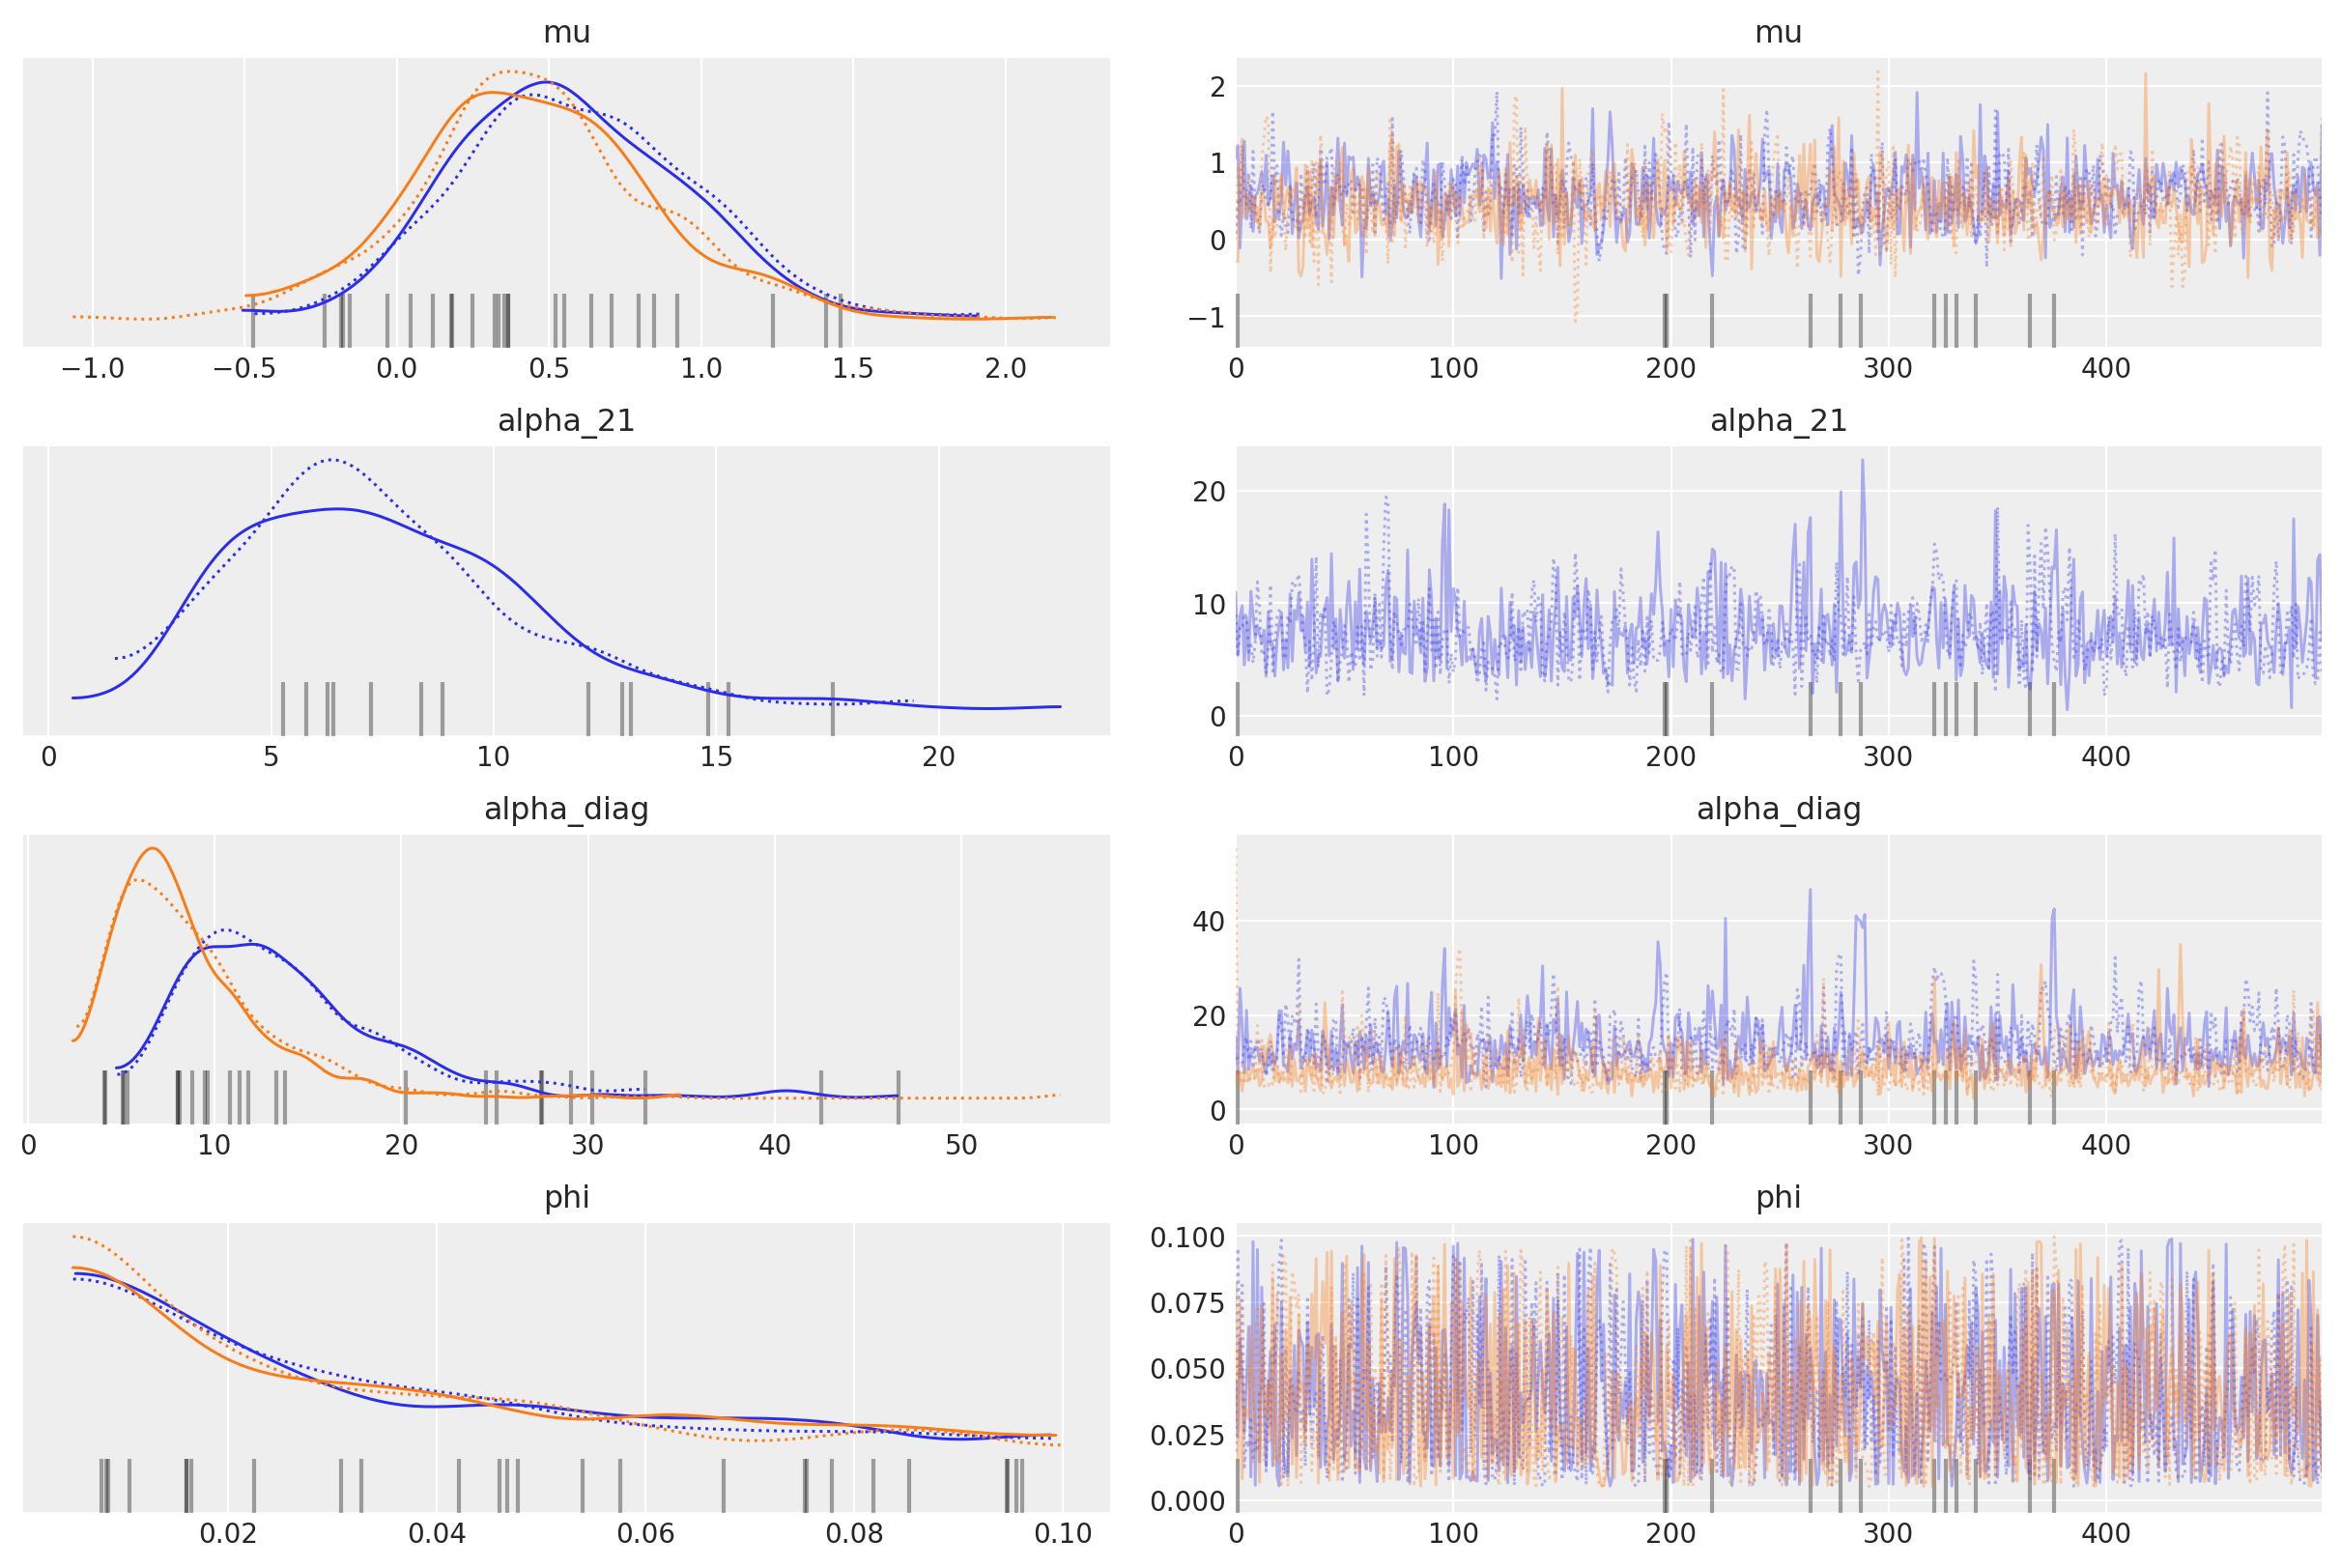

In [ ]:
az.plot_trace(trace, var_names=["mu", "alpha_21", "alpha_diag", "phi"])

## Plot Posterior Distributions

In [ ]:
az.summary(trace, var_names=["mu", "alpha_21", "alpha_diag"])

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
mu[0]           0.580  0.384  -0.056  ...     804.0     639.0    1.0
mu[1]           0.463  0.417  -0.304  ...    1110.0     744.0    1.0
alpha_21        7.468  3.228   1.762  ...     757.0     559.0    1.0
alpha_diag[0]  13.920  5.806   4.761  ...     654.0     446.0    1.0
alpha_diag[1]   8.768  4.613   2.773  ...     858.0     733.0    1.0

[5 rows x 9 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00d81d5390>,
      dtype=object)

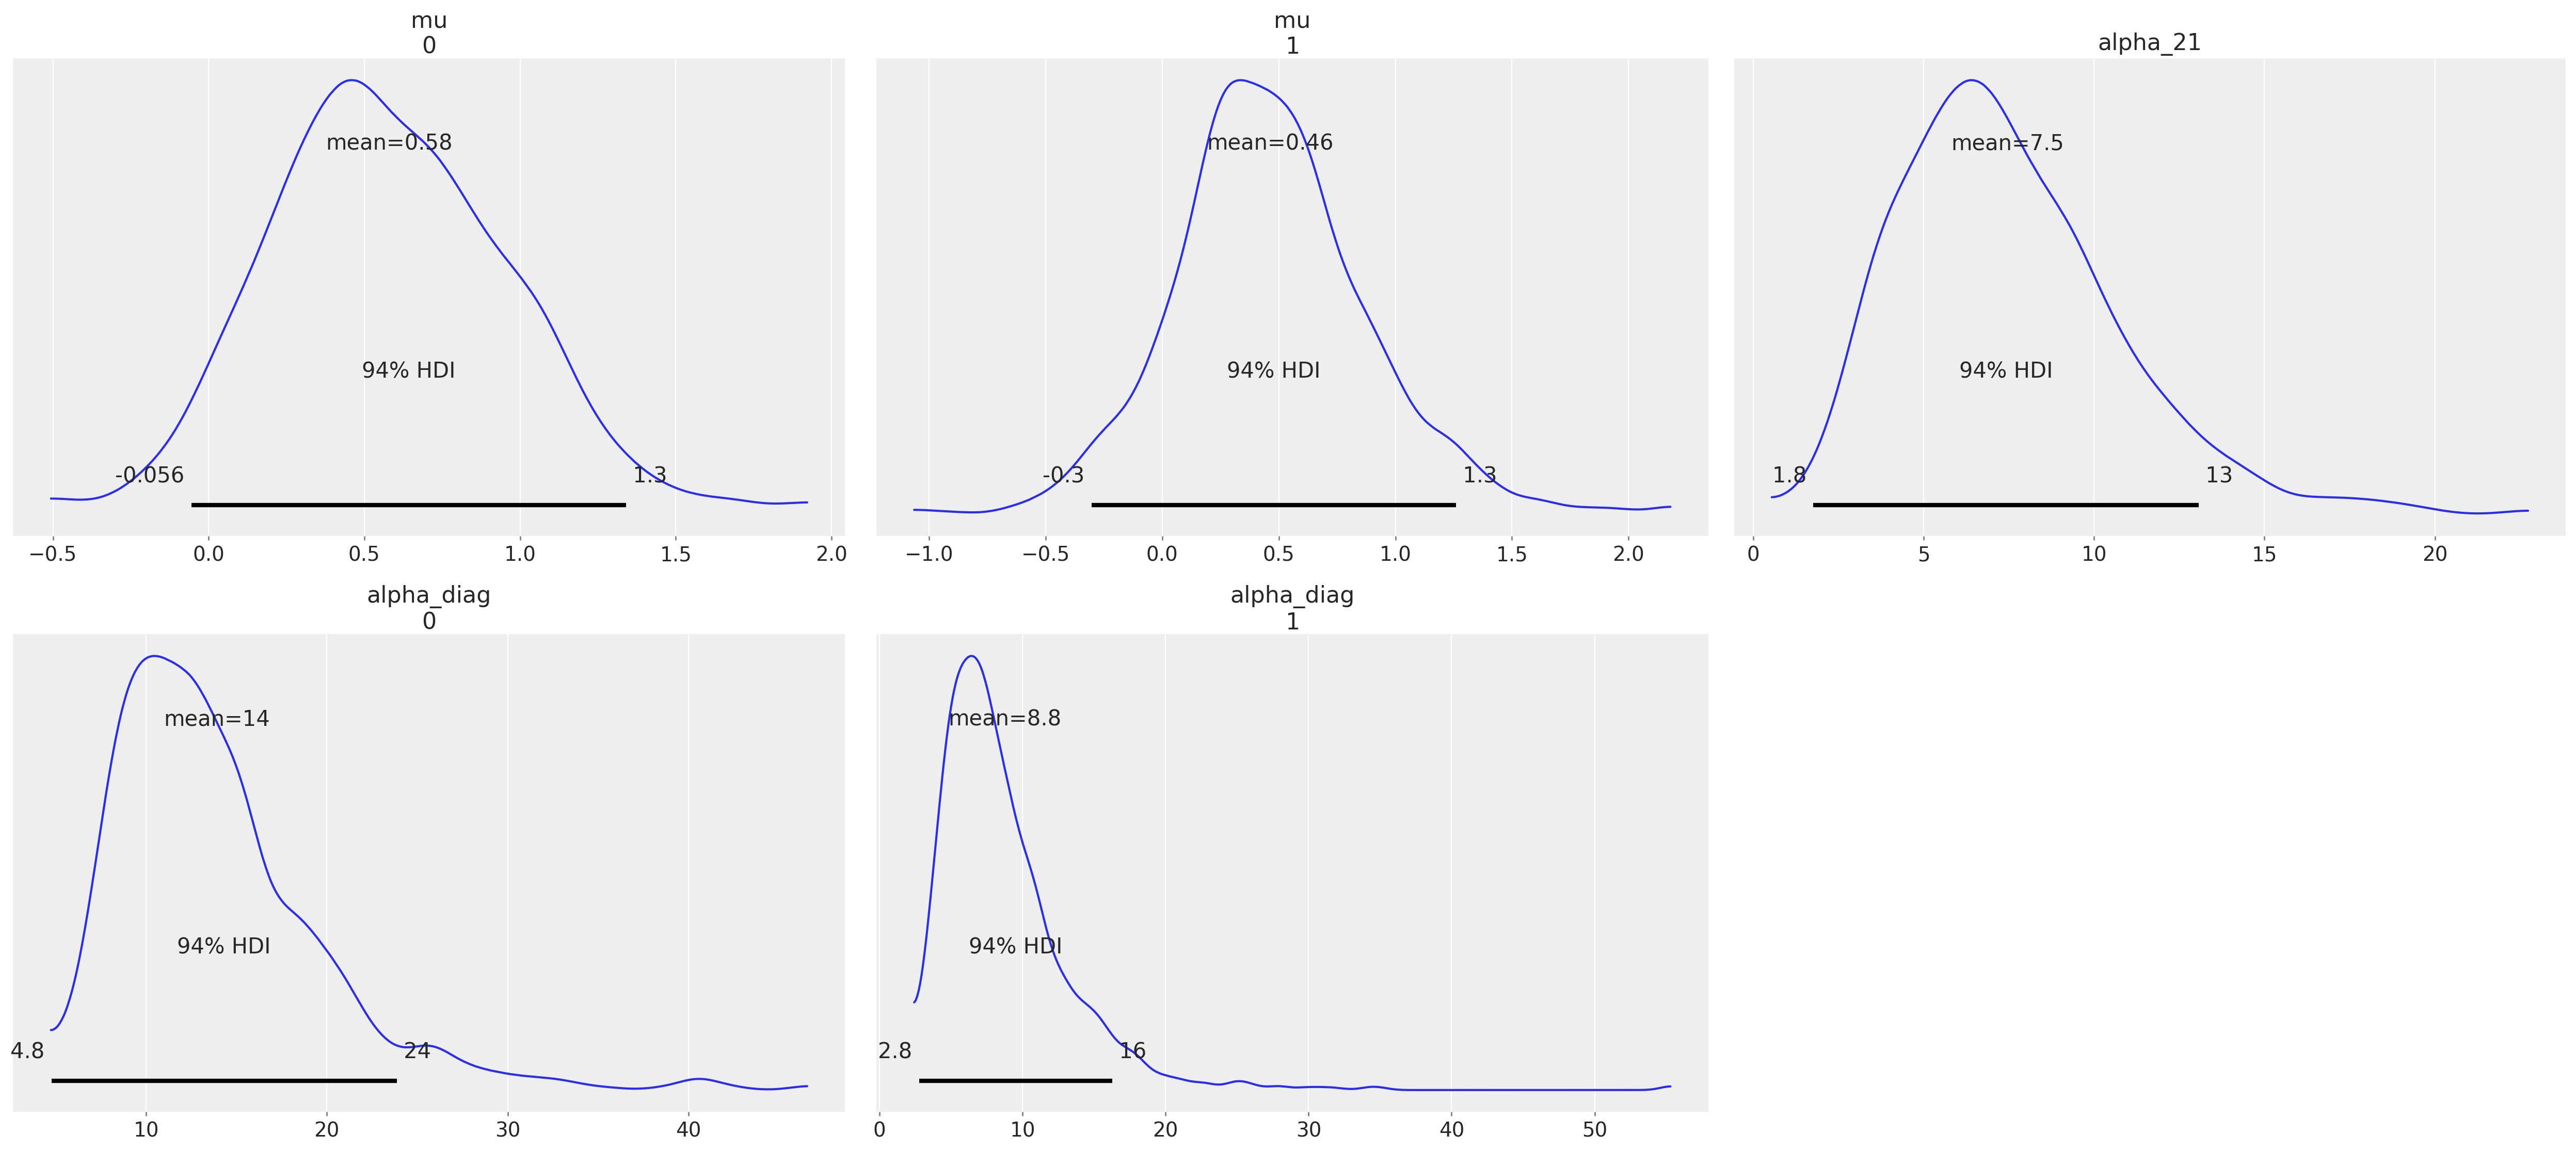

In [ ]:
az.plot_posterior(trace, var_names=["mu", "alpha_21", "alpha_diag"])

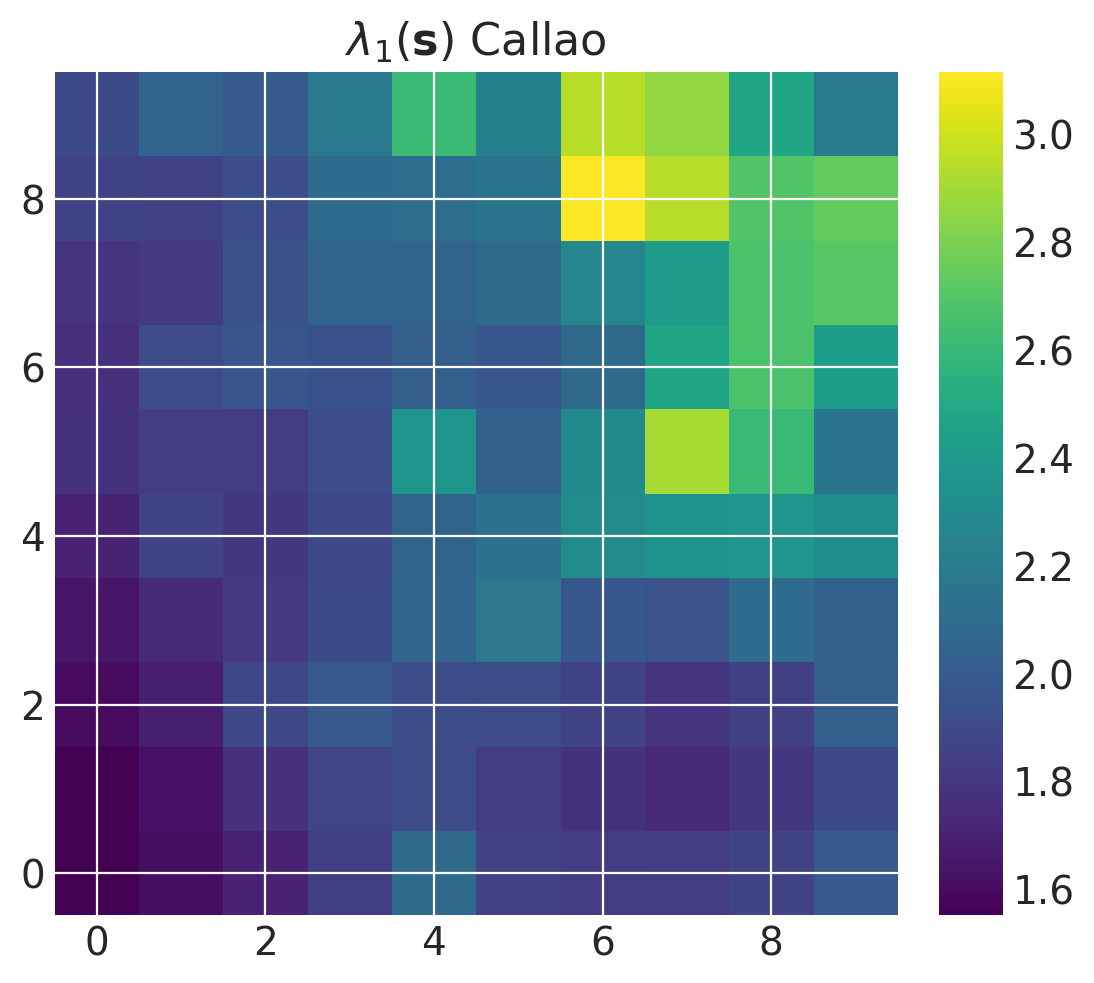

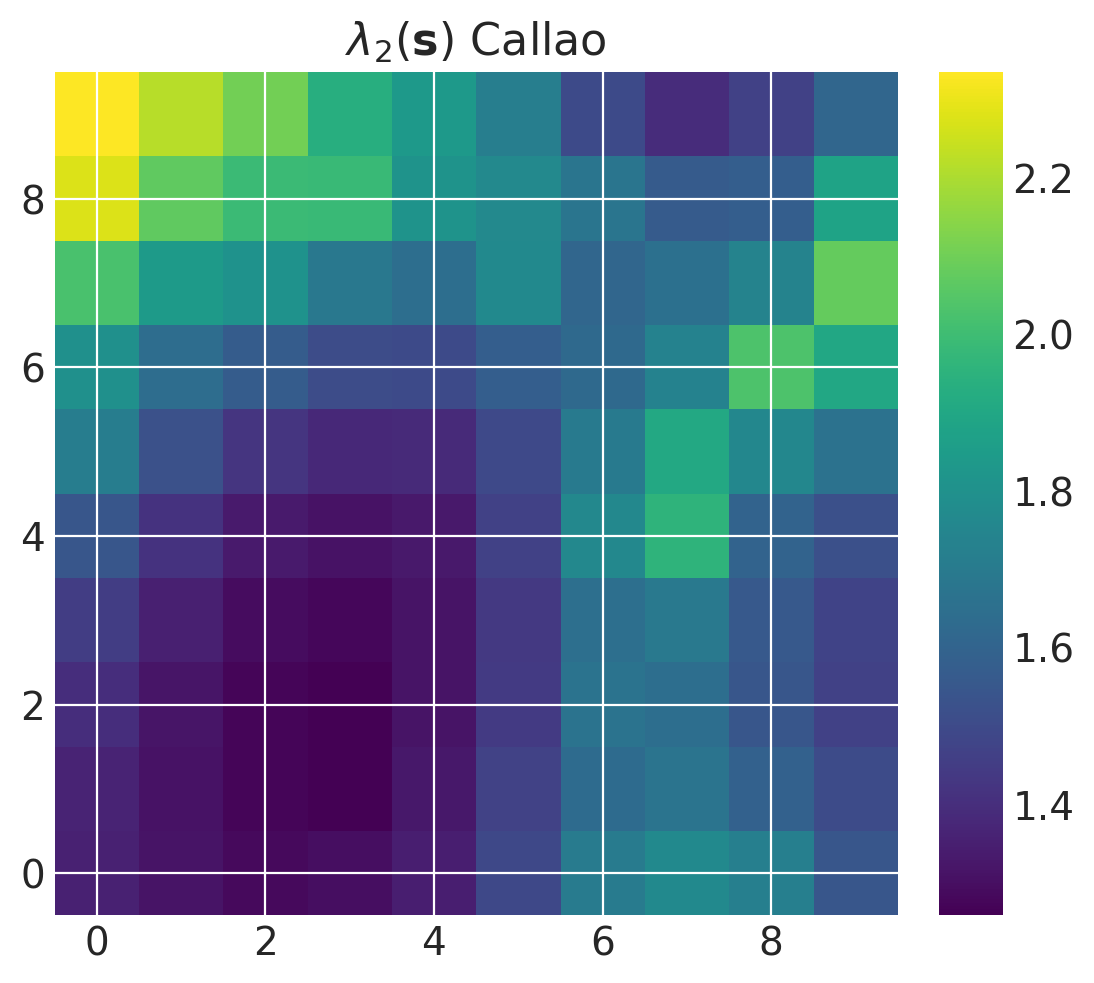

In [ ]:
idx = int(n_draws) # Average over samples
avg_log_intensity_1 = np.mean(np.array(trace.posterior.log_intensity_1[-1,-idx:]), axis = 0)
avg_log_intensity_2 = np.mean(np.array(trace.posterior.log_intensity_2[-1,-idx:]), axis = 0)

plt.figure()

plt.imshow(np.exp(avg_log_intensity_1).reshape(resolution, -1).T, origin='lower')
plt.colorbar()
plt.title('$\lambda_1(\mathbf{s})$ Callao')
plt.show()

plt.figure()

plt.imshow(np.exp(avg_log_intensity_2).reshape(resolution, -1).T, origin='lower')
plt.colorbar()
plt.title('$\lambda_2(\mathbf{s})$ Callao')
plt.show()

# Offshore

## Prepare Data for Model

In [ ]:
# For vd model outputs
xy = offshore_sat_data[['longitude', "latitude"]].values

resolution = 10

cells_x = resolution
cells_y = resolution

# Getting the edge coordinates
min_x, max_x = -77.200927734375, -76.93450927734375
min_y, max_y = -12.545180173463185, -12.301093610658071

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(min_x, max_x, cells_x + 1)
quadrat_y = np.linspace(min_y, max_y, cells_y + 1)

cell_x_size = (max_x - min_x) / cells_x
cell_y_size = (max_y - min_y) / cells_y

area_per_cell = cell_x_size * cell_y_size

# # Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + (cell_x_size / 2.0), 
                                    quadrat_y[:-1] + (cell_y_size / 2.0))))

cell_counts_1, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts_1 = cell_counts_1.ravel().astype(int)

# For ais data
xy = offshore_ais_data[['lon', "lat"]].values

cell_counts_2, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts_2 = cell_counts_2.ravel().astype(int)
assert len(cell_counts_1) == len(cell_counts_2)

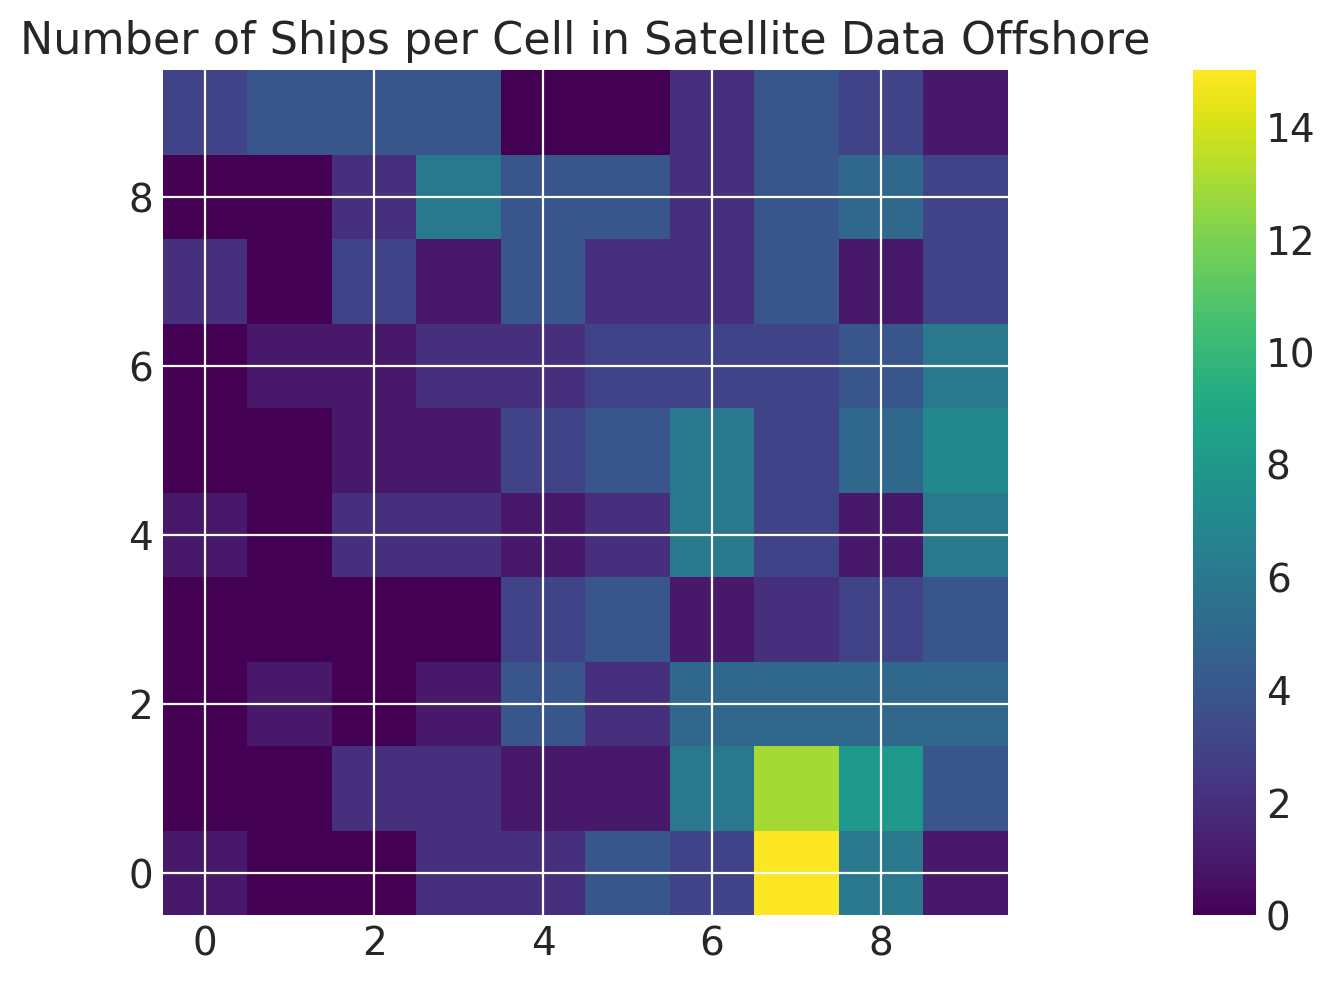

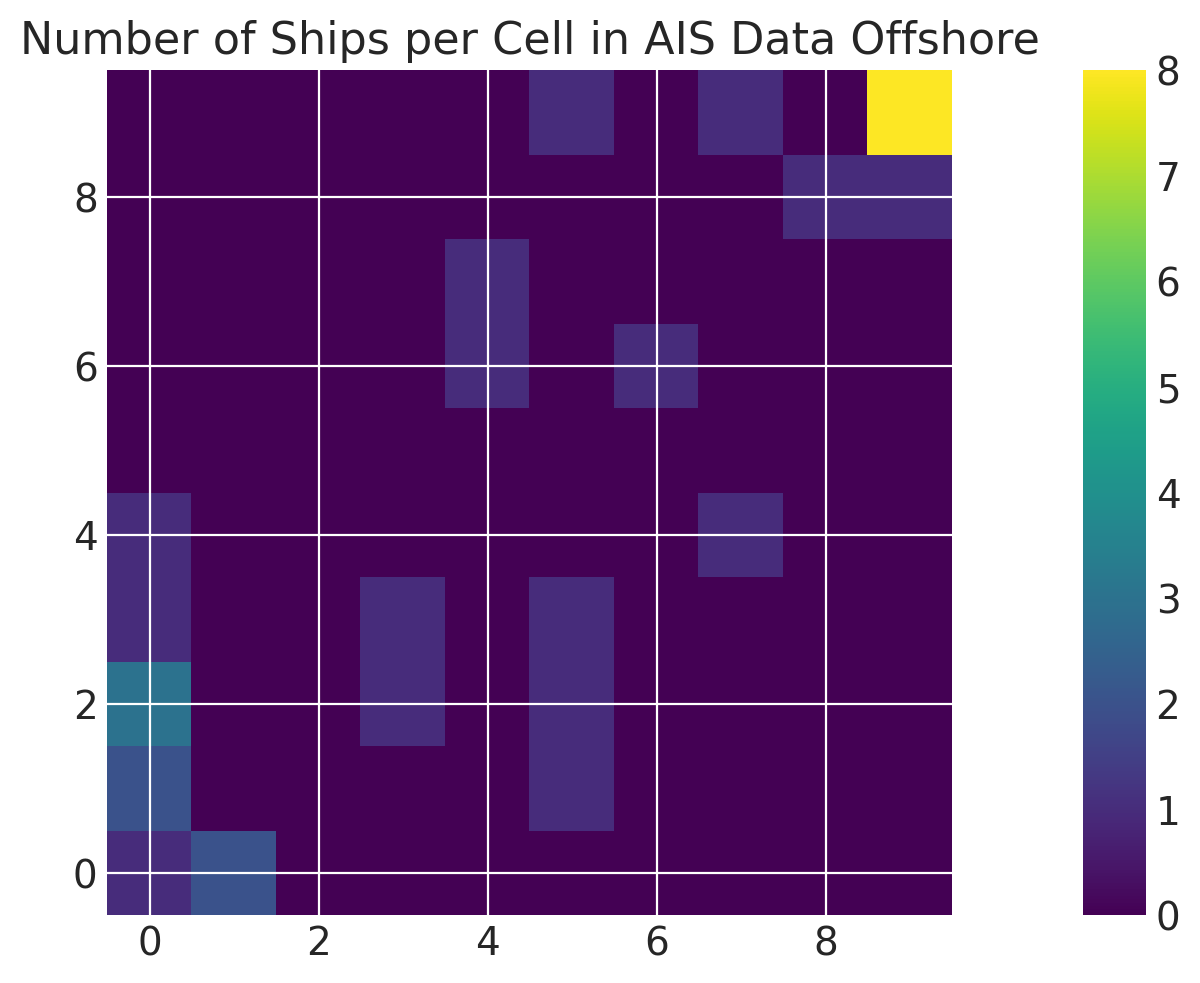

In [ ]:
plt.figure()

plt.imshow(cell_counts_1.reshape(resolution, -1).T, origin='lower')
plt.colorbar()
plt.title('Number of Ships per Cell in Satellite Data Offshore')
plt.show()

plt.figure()

plt.imshow(cell_counts_2.reshape(resolution, -1).T, origin='lower')
plt.colorbar()
plt.title('Number of Ships per Cell in AIS Data Offshore')
plt.show()

## Build Model

In [ ]:
# 'Vectorized" model
with pm.Model() as lgcp_model:
    mu = pm.Normal("mu", mu=0, sigma=1, shape=2)
    phi = pm.Uniform("phi", lower=0.005, upper=0.1, shape=2)
    cov_scale = pm.Exponential("scale", lam=10, shape=2)
    cov_func_1 = cov_scale[0] * pm.gp.cov.Exponential(2, ls=(0.5) \
                                                      * np.sqrt(phi[0]))
    cov_func_2 = cov_scale[1] * pm.gp.cov.Exponential(2, ls=(0.5) \
                                                      * np.sqrt(phi[1]))
    mean_func_1 = pm.gp.mean.Constant(mu[0])
    mean_func_2 = pm.gp.mean.Constant(mu[1])

    gp_1 = pm.gp.Latent(mean_func=mean_func_1, cov_func=cov_func_1)
    gp_2 = pm.gp.Latent(mean_func=mean_func_2, cov_func=cov_func_2)

    # Multitype-scpecific params
    alpha_diag = pm.InverseGamma('alpha_diag', alpha=2.0, beta=2.0, shape=2)
    alpha_21 = pm.Normal('alpha_21', sd=10)

    gp_1_prior = gp_1.prior("log_intensity_1", X=centroids) # Xs must match
    gp_2_prior = gp_2.prior("log_intensity_2", X=centroids) # Xs must match

    log_intensity_1 = alpha_diag[0] * gp_1_prior
    log_intensity_2 = alpha_21 * gp_1_prior + alpha_diag[1] * gp_2_prior 

    intensity_1 = pm.math.exp(log_intensity_1)
    intensity_2 = pm.math.exp(log_intensity_2)

    rates_1 = intensity_1 * area_per_cell
    rates_2 = intensity_2 * area_per_cell
    counts_1 = pm.Poisson("counts_1", mu=rates_1, observed=cell_counts_1)
    counts_2 = pm.Poisson("counts_2", mu=rates_2, observed=cell_counts_2)

## Sample From Posterior

In [ ]:
with lgcp_model:
    #approx = pm.fit() # Variational inference
    n_tune = 500
    n_draws = 500
    trace = pm.sample(tune=n_tune, draws=n_draws, target_accept=0.95, 
                      return_inferencedata=True, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_intensity_2_rotated_, log_intensity_1_rotated_, alpha_21, alpha_diag, scale, phi, mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 5265 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


## Verify Convergence

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01015a5c90>,
      dtype=object)

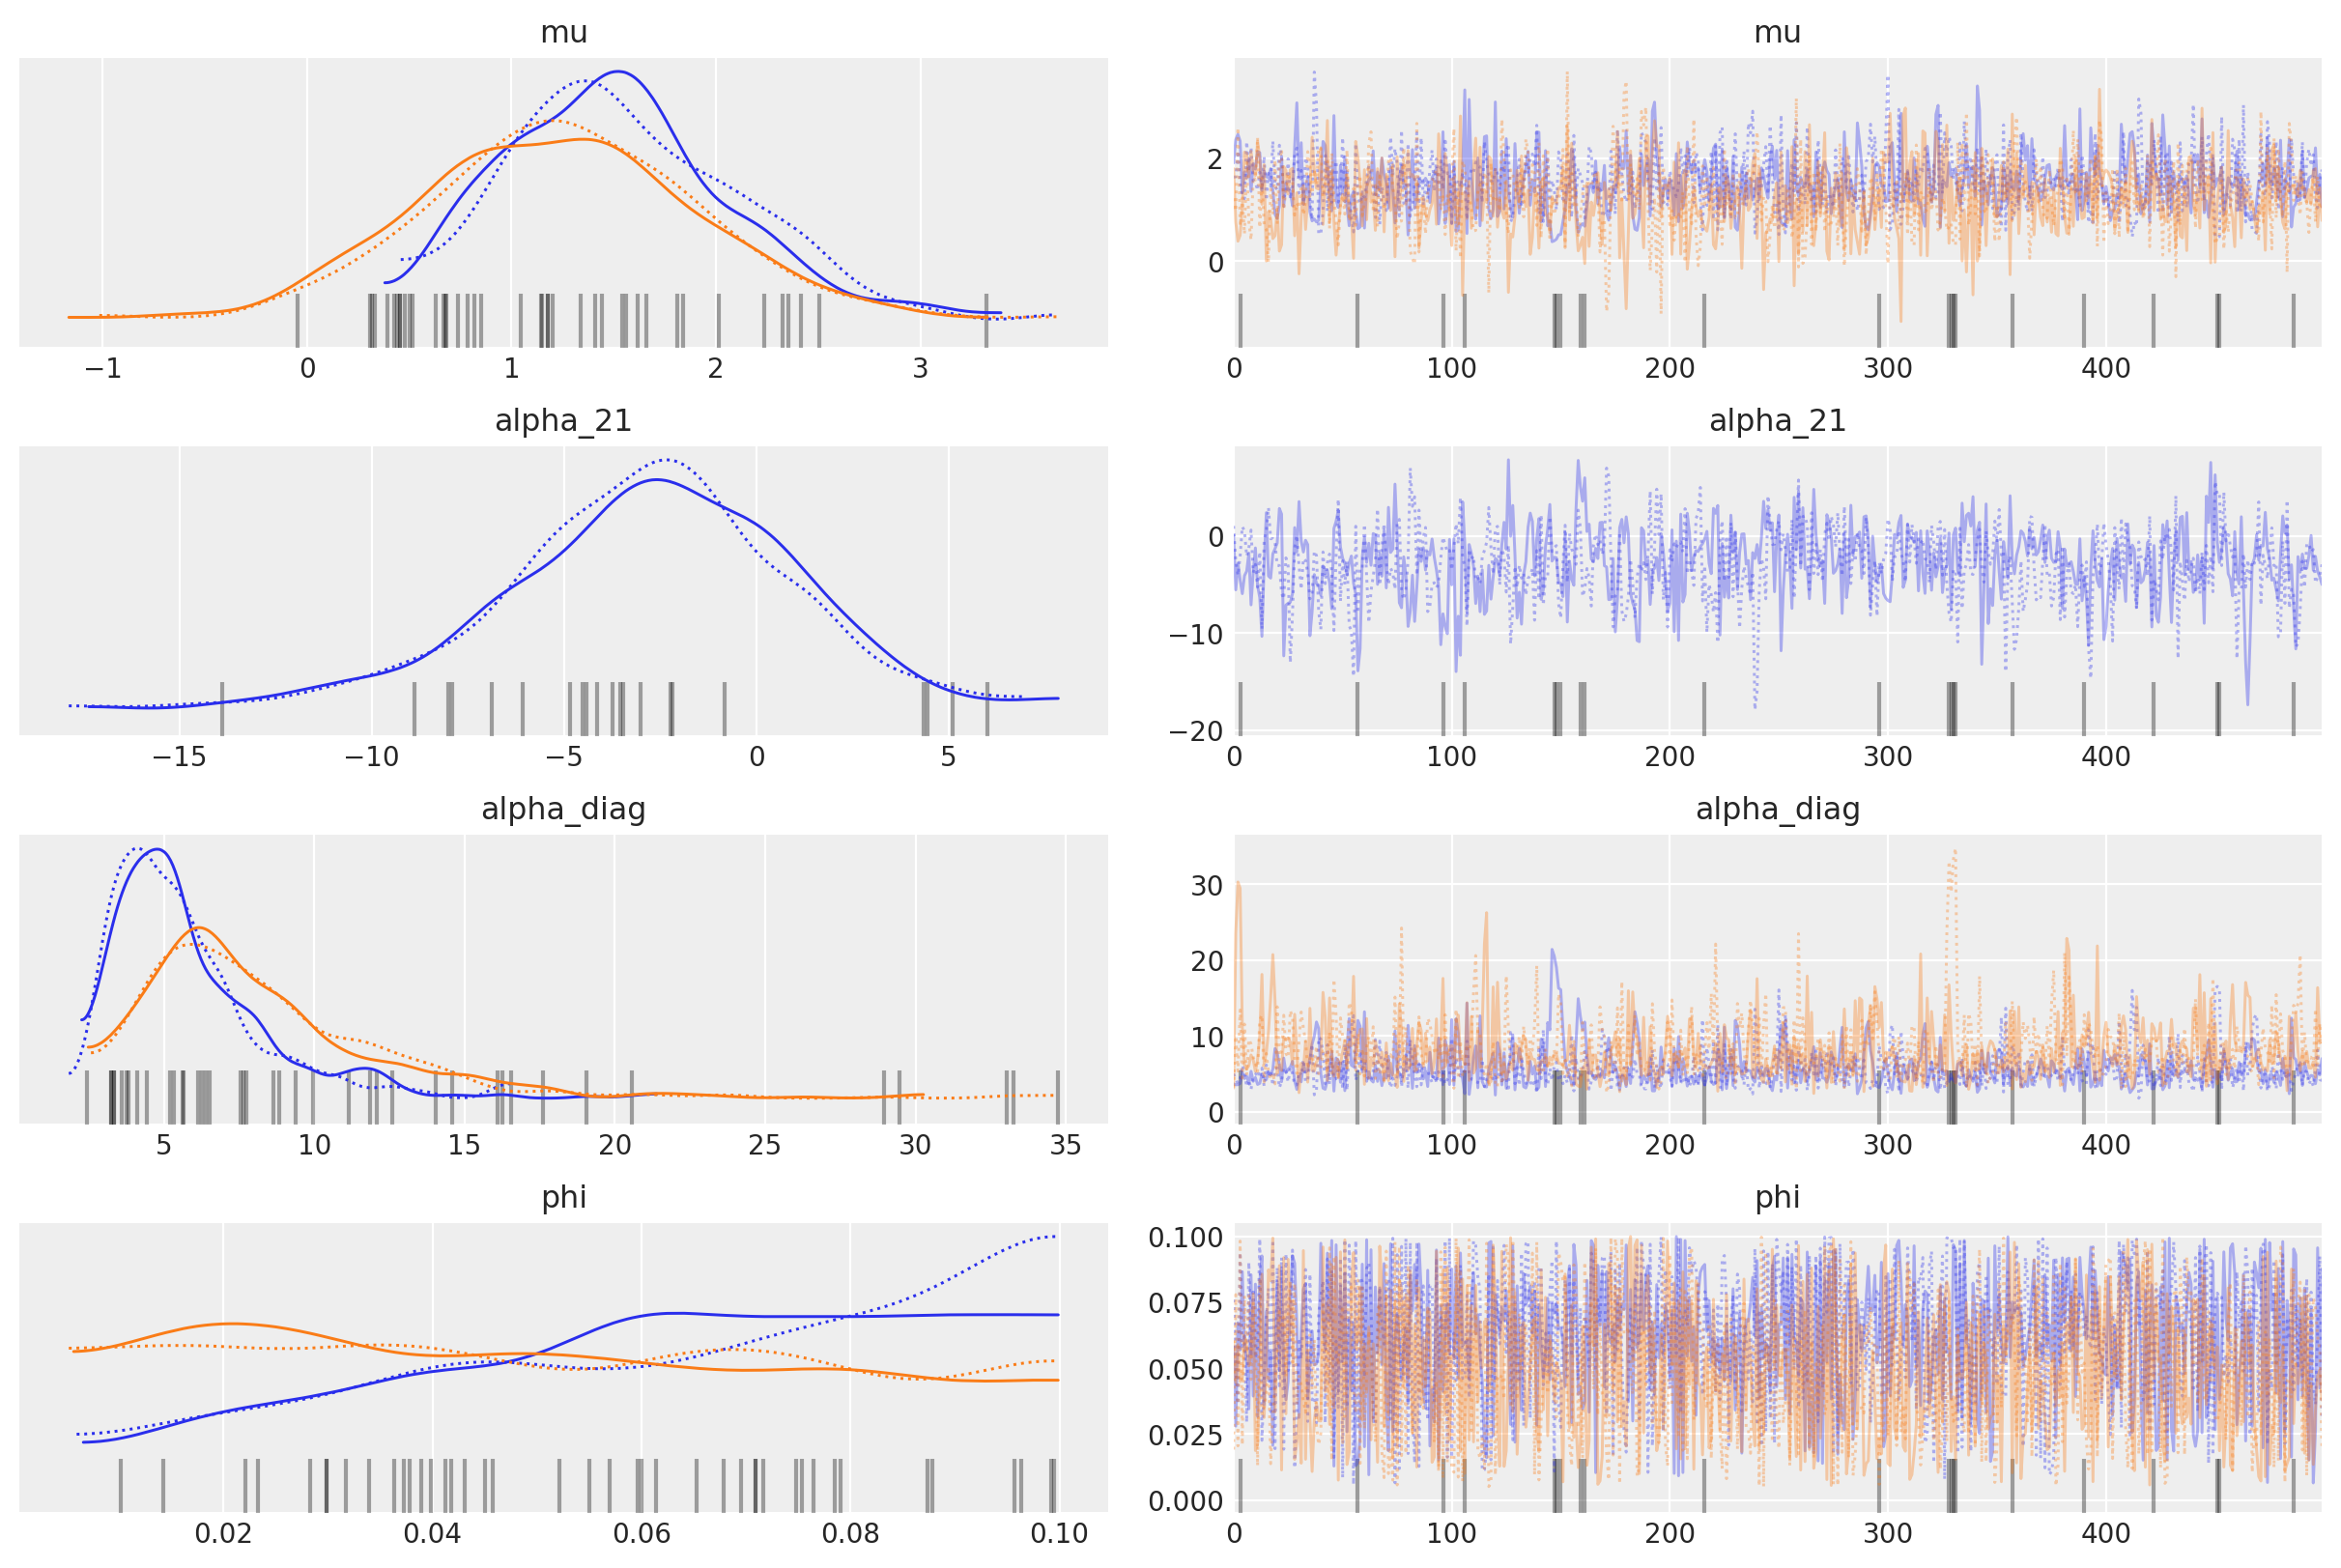

In [ ]:
az.plot_trace(trace, var_names=["mu", "alpha_21", "alpha_diag", "phi"])

## Plot Posterior Distributions

In [ ]:
az.summary(trace, var_names=["mu", "alpha_21", "alpha_diag"])

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
mu[0]          1.538  0.560   0.537  ...     761.0     478.0    1.0
mu[1]          1.237  0.690  -0.024  ...     870.0     825.0    1.0
alpha_21      -2.844  3.729 -10.049  ...     490.0     589.0    1.0
alpha_diag[0]  5.742  2.563   2.242  ...     749.0     453.0    1.0
alpha_diag[1]  8.241  4.136   2.685  ...     783.0     643.0    1.0

[5 rows x 9 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00d6b0b750>,
      dtype=object)

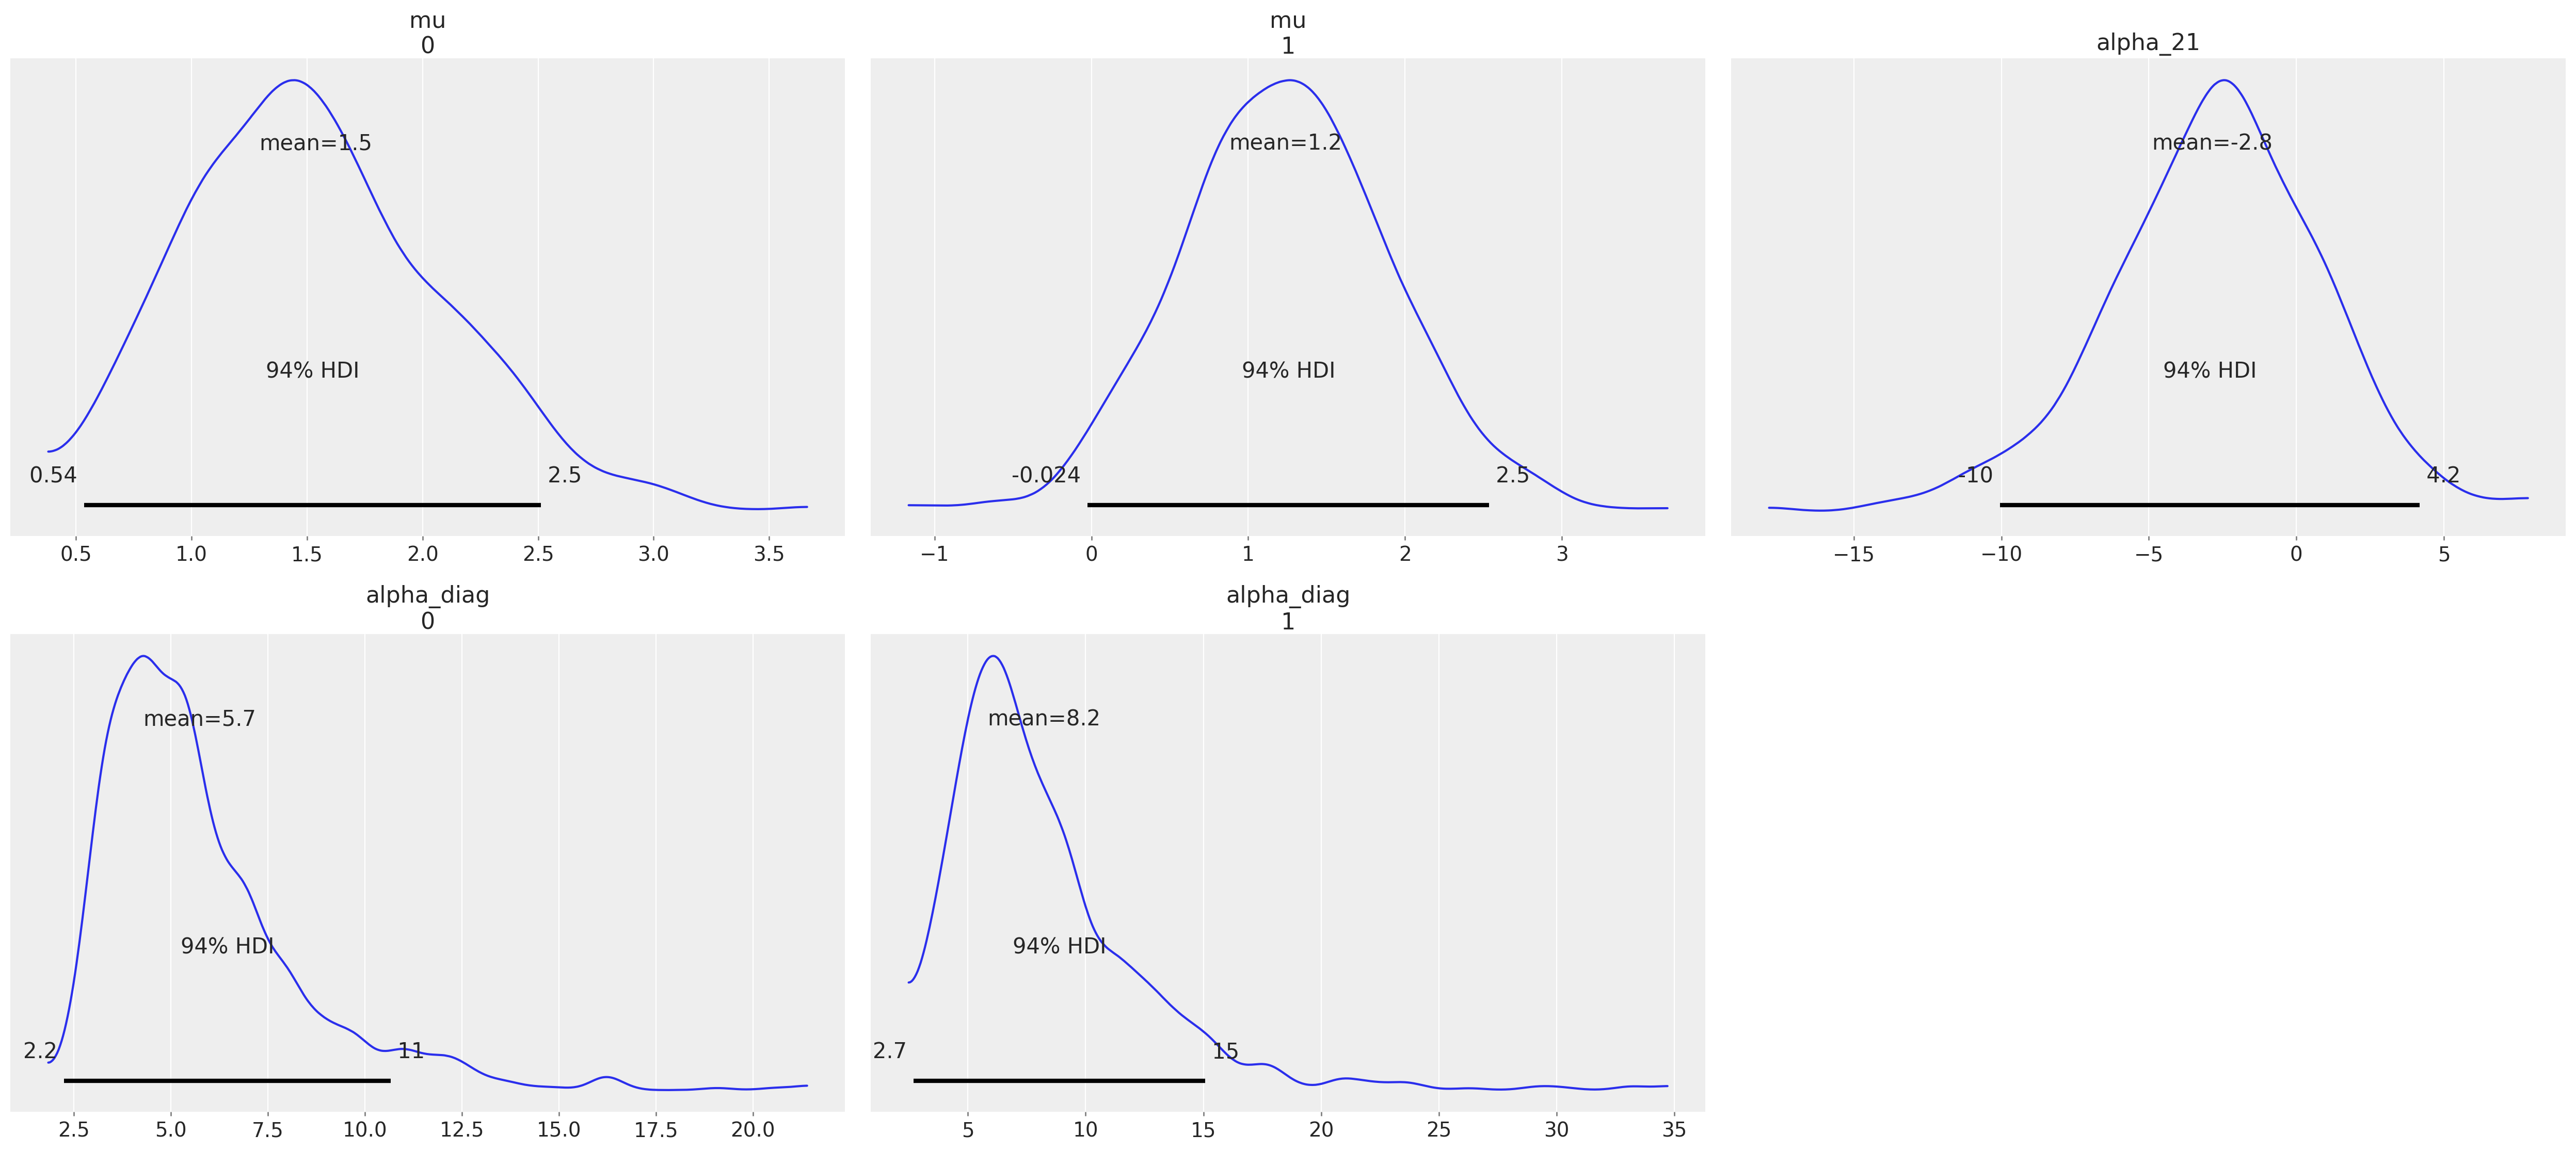

In [ ]:
az.plot_posterior(trace, var_names=["mu", "alpha_21", "alpha_diag"])

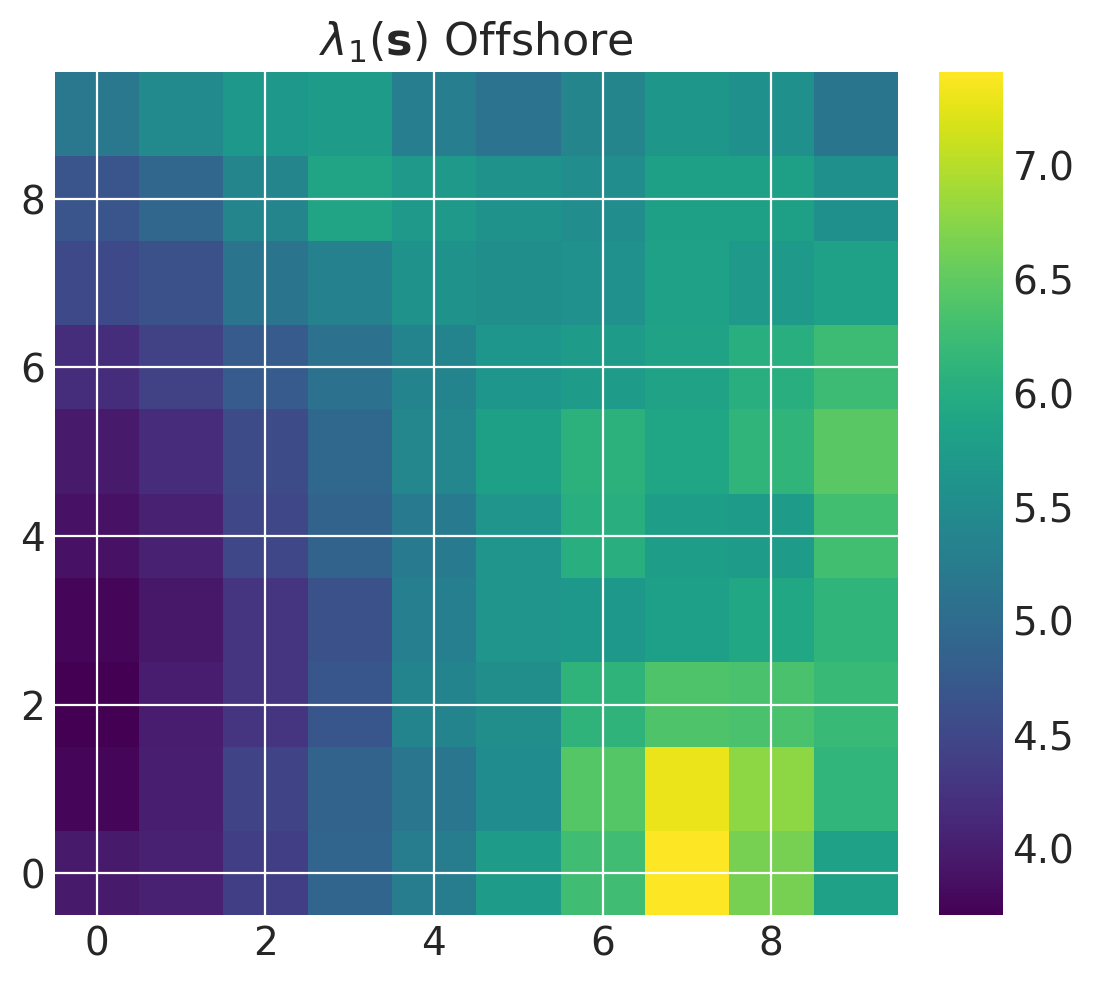

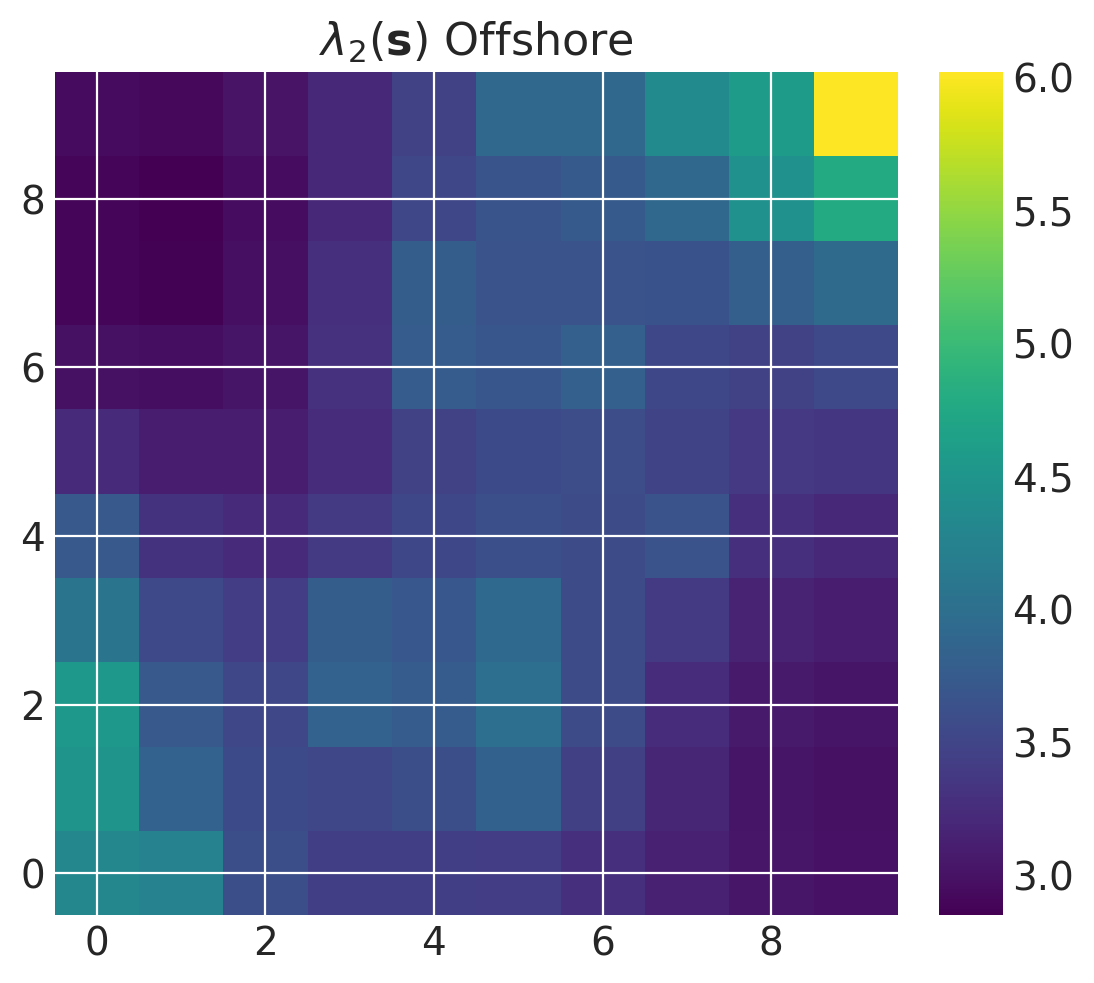

In [ ]:
idx = int(n_draws) # Average over samples
avg_log_intensity_1 = np.mean(np.array(trace.posterior.log_intensity_1[-1,-idx:]), axis = 0)
avg_log_intensity_2 = np.mean(np.array(trace.posterior.log_intensity_2[-1,-idx:]), axis = 0)

plt.figure()

plt.imshow(np.exp(avg_log_intensity_1).reshape(resolution, -1).T, origin='lower')
plt.colorbar()
plt.title('$\lambda_1(\mathbf{s})$ Offshore')
plt.show()

plt.figure()

plt.imshow(np.exp(avg_log_intensity_2).reshape(resolution, -1).T, origin='lower')
plt.colorbar()
plt.title('$\lambda_2(\mathbf{s})$ Offshore')
plt.show()

# Conclusion

In the Callao data, we see that the $94\%$ highest density region (HDI) of the posterior density for $\alpha_{2,1}$ lies between 1.8 and 13. Because of this, we may conclude that there is a positive local spatial dependence between satellite imagery data and AIS data in the Callao region.

For the offshore data, however, the $94\%$ HDI ranges from -10 to 4.2. Based on this, we may conclude that the spatial dependence between the datasets is either very small or negative. This implies that the satellite data captures vessel dynamics which are not present in the AIS data.